In [1]:
!nvidia-smi -L || true
# !pip -q install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121
!pip install einops transforms3d timm pyyaml -q
!pip install torch torchvision -q
!pip install opencv-python scipy gdown matplotlib tqdm -q
print("✅ All packages installed!")

GPU 0: NVIDIA GeForce RTX 3050 6GB Laptop GPU (UUID: GPU-a86d0f03-baec-f4a8-0030-a035ba4f81c5)
✅ All packages installed!


In [1]:
import os, cv2, torch, torch.nn as nn
import numpy as np
from scipy.spatial.transform import Rotation as R
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import gdown, zipfile
import os, math, random, yaml, time, glob
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import transforms3d as t3d
from scipy.spatial import cKDTree
from einops import rearrange, repeat
torch.backends.cudnn.benchmark = True

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# import gdown
# import zipfile
# import os

# # # Google Drive direct download
# # file_id = "1YFUra533pxS_IHsb9tB87lLoxbcHYXt8"
# # output = "linemod.zip"
# # gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# # Use zipfile for .zip archives
# zip_path = "Linemod_preprocessed.zip"
# extract_folder = "LINEMOD_PREPROCESSED"

# if zipfile.is_zipfile(zip_path):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_folder)
#     print("✅ Extracted with zipfile to", extract_folder)
# else:
#     print("File is not a zip file; check upload/download or rename as .zip if needed.")

In [2]:
import os

def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')

# You can change 'LINEMOD_PREPROCESSED' to any other directory you want to inspect
print_directory_structure('LINEMOD_PREPROCESSED')

LINEMOD_PREPROCESSED/
    Linemod_preprocessed/
        data/
            01/
                depth/
                mask/
                rgb/
            02/
                depth/
                mask/
                mask_all/
                rgb/
            04/
                depth/
                mask/
                rgb/
            05/
                depth/
                mask/
                rgb/
            06/
                depth/
                mask/
                rgb/
            08/
                depth/
                mask/
                rgb/
            09/
                depth/
                mask/
                rgb/
            10/
                depth/
                mask/
                rgb/
            11/
                depth/
                mask/
                rgb/
            12/
                depth/
                mask/
                rgb/
            13/
                depth/
                mask/
                rgb/
          

In [3]:
import os, glob, yaml, math
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import cKDTree
from tqdm import tqdm
from einops import rearrange
from scipy.spatial.transform import Rotation as SciR

In [4]:
# -------------------------
# CONFIG
# -------------------------
CFG = {
    "data_root": "LINEMOD_PREPROCESSED/Linemod_preprocessed/data",  # <- set to parent data/ folder
    "models_root": None,               # auto-detected if None (looks one level up for models/)
    "dataset": "linemod",
    "batch_size": 2,
    "num_workers": 0,
    "epochs": 30,
    "lr": 2e-4,
    "wd": 1e-4,
    "img_size": 192,
    "pc_n": 512,
    "rgb_scales": [8,4,2,1],
    "hidden": 96,
    "dropkey_p": 0.1,
    "save_dir": "./ckpts",
    "model_points": "./model_points",   # optional .npy model points per object
}
os.makedirs(CFG["save_dir"], exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# ply_to_npy_converter.py
# Run in the environment where /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models exists.

import os, glob
import numpy as np
from pathlib import Path
import yaml

MODELS_DIR = "LINEMOD_PREPROCESSED/Linemod_preprocessed/models"   # change if needed
OUT_DIR = "models_npy"   # will be created
NUM_SAMPLES = 1024                 # how many model points to save per object

os.makedirs(OUT_DIR, exist_ok=True)

def load_ply_vertices(ply_path):
    verts = []
    header_ended = False
    vcount = 0
    with open(ply_path, 'r') as f:
        for line in f:
            if line.lower().startswith("element vertex"):
                try:
                    vcount = int(line.split()[-1])
                except:
                    vcount = 0
            if 'end_header' in line:
                header_ended = True
                continue
            if header_ended and (vcount == 0 or len(verts) < vcount):
                parts = line.strip().split()
                if len(parts) >= 3:
                    try:
                        x,y,z = float(parts[0]), float(parts[1]), float(parts[2])
                        verts.append([x,y,z])
                    except:
                        pass
    return np.array(verts, dtype=np.float32)

# attempt to read models_info.yml (optional)
models_info_path = os.path.join(MODELS_DIR, "models_info.yml")
models_info = {}
if os.path.exists(models_info_path):
    try:
        with open(models_info_path, 'r') as f:
            models_info = yaml.safe_load(f)
    except Exception as e:
        print("Warning: couldn't read models_info.yml:", e)

# find .ply files
ply_files = sorted(glob.glob(os.path.join(MODELS_DIR, "*.ply")))
if len(ply_files) == 0:
    raise RuntimeError(f"No .ply files found in {MODELS_DIR}")

print(f"Found {len(ply_files)} ply files. Converting to {NUM_SAMPLES} points each...")

for p in ply_files:
    name = Path(p).stem   # e.g. "obj_01" or "01"
    print("Processing:", p, "-> stem:", name)
    pts = load_ply_vertices(p)   # (V, >=3)
    if pts.size == 0:
        print("  WARNING: no vertices extracted, skipping.")
        continue

    # If coordinates look like millimeters (large values), convert to meters
    if np.max(np.abs(pts)) > 10.0:
        pts_m = pts / 1000.0
    else:
        pts_m = pts.copy()

    V = pts_m.shape[0]
    if V >= NUM_SAMPLES:
        idxs = np.random.choice(V, NUM_SAMPLES, replace=False)
        sampled = pts_m[idxs]
    else:
        idxs = np.random.choice(V, NUM_SAMPLES, replace=True)
        sampled = pts_m[idxs]

    # ensure dtype float32
    sampled = sampled.astype(np.float32)

    # save variations so loader will recognize by name:
    # e.g. for obj_01.ply save both "obj_01.npy" and "01.npy" (safe)
    out1 = os.path.join(OUT_DIR, f"{name}.npy")
    np.save(out1, sampled)
    # try to deduce trailing numeric id, save alternate name like "01.npy" or "1.npy"
    parts = name.split("_")
    last = parts[-1]
    try:
        int_id = int(last)   # works for '01' or '1'
        alt1 = os.path.join(OUT_DIR, f"{last}.npy")   # '01.npy' if last is '01'
        alt2 = os.path.join(OUT_DIR, f"{int(int_id)}.npy")  # '1.npy' (no leading zero)
        # save alt1 if different
        if alt1 != out1:
            np.save(alt1, sampled)
        # save alt2 if different
        if alt2 != out1 and alt2 != alt1:
            np.save(alt2, sampled)
    except Exception:
        pass

    print(f"  Saved: {out1} (V={V} -> {sampled.shape[0]} pts)")

print("Done. Model points saved to:", OUT_DIR)
print("Tip: set CFG['model_points'] to this folder and re-run validation to compute ADD/ADD-S.")


Found 15 ply files. Converting to 1024 points each...
Processing: LINEMOD_PREPROCESSED/Linemod_preprocessed/models\obj_01.ply -> stem: obj_01
  Saved: models_npy\obj_01.npy (V=5841 -> 1024 pts)
Processing: LINEMOD_PREPROCESSED/Linemod_preprocessed/models\obj_02.ply -> stem: obj_02
  Saved: models_npy\obj_02.npy (V=38325 -> 1024 pts)
Processing: LINEMOD_PREPROCESSED/Linemod_preprocessed/models\obj_03.ply -> stem: obj_03
  Saved: models_npy\obj_03.npy (V=40759 -> 1024 pts)
Processing: LINEMOD_PREPROCESSED/Linemod_preprocessed/models\obj_04.ply -> stem: obj_04
  Saved: models_npy\obj_04.npy (V=18995 -> 1024 pts)
Processing: LINEMOD_PREPROCESSED/Linemod_preprocessed/models\obj_05.ply -> stem: obj_05
  Saved: models_npy\obj_05.npy (V=22831 -> 1024 pts)
Processing: LINEMOD_PREPROCESSED/Linemod_preprocessed/models\obj_06.ply -> stem: obj_06
  Saved: models_npy\obj_06.npy (V=15736 -> 1024 pts)
Processing: LINEMOD_PREPROCESSED/Linemod_preprocessed/models\obj_07.ply -> stem: obj_07
  Saved: mode

In [6]:
# -------------------------
# Utilities / metrics
# -------------------------
def se3_from_r_t(Rm, t):
    T = np.eye(4, dtype=np.float32)
    T[:3,:3] = Rm
    T[:3,3] = t
    return T

def add_error(model_pts, R_pred, t_pred, R_gt, t_gt):
    P_pred = (R_pred @ model_pts.T).T + t_pred[None,:]
    P_gt   = (R_gt   @ model_pts.T).T + t_gt[None,:]
    return np.mean(np.linalg.norm(P_pred - P_gt, axis=1))

def add_s_error(model_pts, R_pred, t_pred, R_gt, t_gt):
    P_pred = (R_pred @ model_pts.T).T + t_pred[None,:]
    P_gt   = (R_gt   @model_pts.T).T + t_gt[None,:]
    tree = cKDTree(P_gt)
    d, _ = tree.query(P_pred, k=1)
    return np.mean(d)

def rot6d_to_mat(r6):
    # from Zhou et al. 6D representation
    a1 = r6[..., 0:3]
    a2 = r6[..., 3:6]
    b1 = F.normalize(a1, dim=-1)
    b2 = F.normalize(a2 - (b1 * a2).sum(-1, keepdim=True) * b1, dim=-1)
    b3 = torch.cross(b1, b2, dim=-1)
    R = torch.stack([b1, b2, b3], dim=-1)  # (B,3,3)
    return R

In [7]:
# -------------------------
# Utilities / metrics
# -------------------------
def se3_from_r_t(Rm, t):
    T = np.eye(4, dtype=np.float32)
    T[:3,:3] = Rm
    T[:3,3] = t
    return T

def add_error(model_pts, R_pred, t_pred, R_gt, t_gt):
    P_pred = (R_pred @ model_pts.T).T + t_pred[None,:]
    P_gt   = (R_gt   @ model_pts.T).T + t_gt[None,:]
    return np.mean(np.linalg.norm(P_pred - P_gt, axis=1))

def add_s_error(model_pts, R_pred, t_pred, R_gt, t_gt):
    P_pred = (R_pred @ model_pts.T).T + t_pred[None,:]
    P_gt   = (R_gt   @model_pts.T).T + t_gt[None,:]
    tree = cKDTree(P_gt)
    d, _ = tree.query(P_pred, k=1)
    return np.mean(d)

def rot6d_to_mat(r6):
    # from Zhou et al. 6D representation
    a1 = r6[..., 0:3]
    a2 = r6[..., 3:6]
    b1 = F.normalize(a1, dim=-1)
    b2 = F.normalize(a2 - (b1 * a2).sum(-1, keepdim=True) * b1, dim=-1)
    b3 = torch.cross(b1, b2, dim=-1)
    R = torch.stack([b1, b2, b3], dim=-1)  # (B,3,3)
    return R

In [8]:
# -------------------------
# Dataset
# -------------------------
class LinemodDataset(Dataset):
    """
    LINEMOD preprocessed loader (depth-backed point clouds).
    Expects:
      <data_root>/
         01/
           rgb/
           depth/
           mask/   (or mask_all/)
           gt.yml
           info.yml
    models/ folder expected at parent of data_root.
    """
    def __init__(self, data_root, img_size=192, num_points=512, split='train'):
        super().__init__()
        self.root = Path(data_root)
        self.img_size = img_size
        self.num_points = num_points

        # find object folders (two-char names) - ignore non-dirs
        self.obj_dirs = sorted([p.name for p in self.root.iterdir() if p.is_dir()])
        if len(self.obj_dirs) == 0:
            raise RuntimeError(f"No object folders detected in {data_root}")

        # detect models folder (one level up /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models)
        parent = self.root.parent
        models_folder = parent / "models"
        if not models_folder.exists():
            # fallback to ../.. in case of nested dirs
            models_folder = parent.parent / "models"
        self.models_folder = str(models_folder) if models_folder.exists() else None

        # build mapping and samples list
        self.obj2id = {od:i for i,od in enumerate(self.obj_dirs)}
        self.id2obj = {i:od for od,i in self.obj2id.items()}
        self.samples = []
        self.model_points = {}
        # load models if available
        if self.models_folder:
            self._load_models_from_folder(self.models_folder)

        # iterate object folders, reading gt.yml, info.yml and frames
        for od in self.obj_dirs:
            od_path = self.root / od
            rgb_folder = od_path / "rgb"
            if not rgb_folder.exists():
                continue
            info_path = od_path / "info.yml"
            gt_path = od_path / "gt.yml"
            intr = self._read_info(info_path)
            gt_map = self._read_gt(gt_path)

            # handle mask folder names
            mask_folder = od_path / "mask"
            if not mask_folder.exists() and (od_path / "mask_all").exists():
                mask_folder = od_path / "mask_all"

            rgb_files = sorted(list(rgb_folder.glob("*.png")) + list(rgb_folder.glob("*.jpg")))
            for rf in rgb_files:
                stem = rf.stem
                try:
                    idx = int(stem)
                except:
                    continue
                sample = {
                    'obj_id_str': od,
                    'obj_id': self.obj2id[od],
                    'rgb': str(rf),
                    'mask': str(mask_folder / f"{stem}.png") if mask_folder.exists() else None,
                    'depth': str(od_path / "depth" / f"{stem}.png"),
                    'intrinsics': intr,
                    'pose': gt_map.get(str(idx), gt_map.get(idx, None)),
                    'frame_idx': idx,
                    'obj_folder': str(od_path)
                }
                if (os.path.exists(sample['rgb']) and os.path.exists(sample['depth']) and sample['pose'] is not None):
                    # mask may be optional — allow missing mask but warn
                    if sample['mask'] is None or not os.path.exists(sample['mask']):
                        sample['mask'] = None
                    self.samples.append(sample)

        print(f"Loaded Linemod dataset: {len(self.samples)} samples for {len(self.obj_dirs)} objects.")
        print("models folder:", self.models_folder)

    def _read_info(self, info_path):
        K_default = {'fx': 572.4114, 'fy': 573.57043, 'cx': 325.2611, 'cy': 242.04899}
        if info_path is None or not Path(info_path).exists():
            return K_default
        try:
            with open(info_path, 'r') as f:
                info = yaml.safe_load(f)
        except:
            return K_default
        # cam_K flat 9
        if 'cam_K' in info:
            k = info['cam_K']
            if isinstance(k, (list,tuple)) and len(k)>=9:
                return {'fx':float(k[0]), 'fy':float(k[4]), 'cx':float(k[2]), 'cy':float(k[5])}
        for key in ('intrinsic_matrix','K','camera_matrix','cam_mat','intrinsics'):
            if key in info:
                k = info[key]
                if isinstance(k, (list,tuple)) and len(k)>=9:
                    return {'fx':float(k[0]), 'fy':float(k[4]), 'cx':float(k[2]), 'cy':float(k[5])}
                if isinstance(k, dict):
                    return {'fx':float(k.get('fx', K_default['fx'])),
                            'fy':float(k.get('fy', K_default['fy'])),
                            'cx':float(k.get('cx', K_default['cx'])),
                            'cy':float(k.get('cy', K_default['cy']))}
        return K_default

    def _read_gt(self, gt_path):
      if not gt_path or not os.path.exists(gt_path):
        return {}

      try:
          with open(gt_path, 'r') as f:
              gt = yaml.safe_load(f)
      except Exception:
          return {}

      def extract_R_t(obj):
          """Recursively try to find (R, t) inside obj. Return (R_np, t_np) or (None, None)."""
          # direct dict with known keys
          if isinstance(obj, dict):
              # check common keys first
              for rkey in ('cam_R_m2c', 'cam_R', 'R', 'rotation', 'rot'):
                  if rkey in obj:
                      try:
                          Rm = np.array(obj[rkey], dtype=np.float32)
                      except Exception:
                          Rm = None
                      else:
                          if Rm.size == 9:
                              Rm = Rm.reshape(3,3)
                          # else allow if already proper shape
                      break
                  else:
                      Rm = None
              for tkey in ('cam_t_m2c', 'cam_t', 't', 'translation', 'trans'):
                  if tkey in obj:
                      try:
                          tm = np.array(obj[tkey], dtype=np.float32)
                      except Exception:
                          tm = None
                      break
                  else:
                      tm = None

              # If both found and well-shaped, return
              if Rm is not None and tm is not None:
                  try:
                      Rm = Rm.reshape(3,3)
                      tm = tm.reshape(3,)
                      return Rm.astype(np.float32), tm.astype(np.float32)
                  except Exception:
                      pass

              # otherwise recursively search nested values
              for val in obj.values():
                  Rm2, tm2 = extract_R_t(val)
                  if Rm2 is not None and tm2 is not None:
                      return Rm2, tm2
              return (None, None)

          # if list / tuple / ndarray
          if isinstance(obj, (list, tuple, np.ndarray)):
              # try flattened numeric array (3x4 or longer)
              try:
                  arr = np.array(obj, dtype=np.float32)
                  if arr.size >= 12:
                      flat = arr.reshape(-1)
                      Rm = flat[0:9].reshape(3,3)
                      tm = flat[9:12]
                      return Rm.astype(np.float32), tm.astype(np.float32)
              except Exception:
                  pass
              # else, maybe it's a list of dicts/entries — search each
              for item in obj:
                  Rm2, tm2 = extract_R_t(item)
                  if Rm2 is not None and tm2 is not None:
                      return Rm2, tm2
              return (None, None)

          # nothing found
          return (None, None)

      parsed = {}

      # Case 1: gt is a mapping index->entry
      if isinstance(gt, dict):
          for k, v in gt.items():
              Rm, tm = extract_R_t(v)
              if Rm is not None and tm is not None:
                  # convert mm->m if needed
                  if np.linalg.norm(tm) > 10.0:
                      tm = tm / 1000.0
                  try:
                      parsed[str(k)] = {'R': Rm.astype(np.float32), 't': tm.astype(np.float32)}
                      parsed[int(k)] = parsed[str(k)]
                  except Exception:
                      parsed[str(k)] = {'R': Rm.astype(np.float32), 't': tm.astype(np.float32)}
      # Case 2: gt is a list (each entry might include a frame index inside or be ordered)
      elif isinstance(gt, (list, tuple)):
          for i, item in enumerate(gt):
              Rm, tm = extract_R_t(item)
              if Rm is not None and tm is not None:
                  if np.linalg.norm(tm) > 10.0:
                      tm = tm / 1000.0
                  # some lists include explicit frame idx inside item
                  frame_keys = []
                  if isinstance(item, dict):
                      # try to find an index-like key inside item
                      for candidate in ('frame', 'idx', 'index', 'image_id', 'cam_idx'):
                          if candidate in item:
                              try:
                                  frame_keys.append(int(item[candidate]))
                              except Exception:
                                  pass
                  # prefer explicit frame key if found, else use list position
                  if frame_keys:
                      fi = frame_keys[0]
                  else:
                      fi = i
                  parsed[str(fi)] = {'R': Rm.astype(np.float32), 't': tm.astype(np.float32)}
                  try:
                      parsed[int(fi)] = parsed[str(fi)]
                  except Exception:
                      pass
      else:
          # unexpected structure — try to extract top-level
          Rm, tm = extract_R_t(gt)
          if Rm is not None and tm is not None:
              parsed['0'] = {'R': Rm.astype(np.float32), 't': tm.astype(np.float32)}
              try:
                  parsed[0] = parsed['0']
              except:
                  pass

      return parsed

    def _load_models_from_folder(self, models_folder, num_model_pts=1024):
      ply_list = glob.glob(os.path.join(models_folder, '*.ply'))
      if len(ply_list) == 0:
          return

      for od in self.obj_dirs:
          # try to match filenames containing the folder id or common patterns
          candidates = []
          for p in ply_list:
              name = os.path.basename(p).lower()
              if od in name or f"obj_{int(od)}" in name or f"obj{int(od)}" in name or f"_{od}." in name:
                  candidates.append(p)
          if len(candidates) == 0 and len(ply_list) > 0:
              candidates = [ply_list[0]]
          if not candidates:
              continue
          ply_path = candidates[0]
          try:
              pts = self._load_ply_vertices(ply_path)  # (V, >=3)
              if pts.shape[1] > 3:
                  pts = pts[:, :3]
              V = pts.shape[0]
              if V >= num_model_pts:
                  idxs = np.random.choice(V, num_model_pts, replace=False)
                  pts_samp = pts[idxs]
              else:
                  # repeat with replacement
                  idxs = np.random.choice(V, num_model_pts, replace=True)
                  pts_samp = pts[idxs]
              self.model_points[od] = pts_samp.astype(np.float32)
          except Exception as e:
              print(f"Failed loading model for {od} from {ply_path}: {e}")


    def _load_ply_vertices(self, ply_path):
        verts = []
        header_ended = False
        vcount = 0
        with open(ply_path,'r') as f:
            for line in f:
                if 'element vertex' in line:
                    vcount = int(line.split()[-1])
                if 'end_header' in line:
                    header_ended = True
                    continue
                if header_ended and len(verts) < vcount:
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        verts.append([float(parts[0]), float(parts[1]), float(parts[2])])
        return np.array(verts, dtype=np.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
      s = self.samples[idx]

      # --- load depth first (keep original resolution for backprojection) ---
      depth = cv2.imread(s['depth'], cv2.IMREAD_UNCHANGED)
      if depth is None:
          raise ValueError("Missing depth: " + s['depth'])
      depth_f = depth.astype(np.float32)
      # convert mm->m if needed
      if depth_f.max() > 10.0:
          depth_f = depth_f / 1000.0
      H_depth, W_depth = depth_f.shape

      # --- load mask (if present) and resize to depth resolution) ---
      mask_bin = None
      if s['mask'] and os.path.exists(s['mask']):
          mask = cv2.imread(s['mask'], cv2.IMREAD_GRAYSCALE)
          if mask is None:
              mask_bin = None
          else:
              # resize mask to depth shape (nearest neighbor to preserve binary nature)
              if (mask.shape[0], mask.shape[1]) != (H_depth, W_depth):
                  mask = cv2.resize(mask, (W_depth, H_depth), interpolation=cv2.INTER_NEAREST)
              mask_bin = (mask > 127).astype(np.uint8)
      else:
          mask_bin = None

      # --- load rgb for network input (resize to img_size) ---
      rgb = cv2.imread(s['rgb'], cv2.IMREAD_COLOR)
      if rgb is None:
          raise ValueError("Missing rgb: " + s['rgb'])
      rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
      rgb_resized = cv2.resize(rgb, (self.img_size, self.img_size)).astype(np.float32) / 255.0
      rgb_t = torch.from_numpy(rgb_resized).permute(2,0,1).float()

      # --- intrinsics ---
      K = s['intrinsics']
      fx, fy, cx, cy = float(K['fx']), float(K['fy']), float(K['cx']), float(K['cy'])

      # IMPORTANT: if intrinsics were computed for a different resolution (rare),
      # you would need to scale cx,cy,fx,fy accordingly to the depth resolution.
      # Here we assume intrinsics match the depth image resolution.

      # --- backproject masked (or all valid) depth pixels to 3D in camera coords ---
      if mask_bin is not None:
          ys, xs = np.where((mask_bin > 0) & (depth_f > 0))
      else:
          ys, xs = np.where(depth_f > 0)

      if len(xs) == 0:
          # fallback: use any valid depth pixels
          ys, xs = np.where(depth_f > 0)
      zs = depth_f[ys, xs]
      us = xs.astype(np.float32)
      vs = ys.astype(np.float32)

      X = (us - cx) * zs / fx
      Y = (vs - cy) * zs / fy
      Z = zs
      pts = np.stack([X, Y, Z], axis=1)   # (M,3)

      # --- sample / pad to self.num_points ---
      if pts.shape[0] >= self.num_points:
          sel = np.random.choice(pts.shape[0], self.num_points, replace=False)
          pts_samp = pts[sel]
      else:
          if pts.shape[0] == 0:
              pts_samp = np.zeros((self.num_points, 3), dtype=np.float32)
          else:
              sel = np.random.choice(pts.shape[0], self.num_points, replace=True)
              pts_samp = pts[sel]

      pc = torch.from_numpy(pts_samp.astype(np.float32))

      # --- GT pose ---
      p = s['pose']
      R_gt = torch.from_numpy(p['R'].astype(np.float32))
      t_gt = torch.from_numpy(p['t'].astype(np.float32))

      # --- model points ---
      mp = self.model_points.get(s['obj_id_str'], None)
      if mp is None:
          mp = (np.random.rand(1024,3)-0.5).astype(np.float32)

      # ensure tensors are regular (not numpy-backed readonly views)
      pc = torch.from_numpy(pts_samp.astype(np.float32)).contiguous().clone()   # (N,3)
      rgb_t = torch.from_numpy(rgb_resized.astype(np.float32)).permute(2,0,1).contiguous().clone()  # (3,H,W)
      R_gt = torch.from_numpy(p['R'].astype(np.float32)).contiguous().clone()   # (3,3)
      t_gt = torch.from_numpy(p['t'].astype(np.float32)).contiguous().clone()   # (3,)

      # model points: ensure fixed-size numpy was created earlier; convert to tensor and clone
      mp_arr = self.model_points.get(s['obj_id_str'], None)
      if mp_arr is None:
          mp_arr = (np.random.rand(1024,3)-0.5).astype(np.float32)
      model_points = torch.from_numpy(mp_arr.astype(np.float32)).contiguous().clone()  # (M,3) fixed M

      return {
          "rgb": rgb_t,
          "pc": pc,
          "R_gt": R_gt,
          "t_gt": t_gt,
          "obj_id": torch.tensor(s['obj_id'], dtype=torch.long),
          "object": s['obj_id_str'],            # keep object string if you want; collate will make a list of strings
          "model_points": model_points
      }


In [9]:
# -------------------------
# Model - (kept from your code with minor cleanups)
# -------------------------
# --- small building blocks (DW separable conv) ---
class DWSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=7, s=4, p=3):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, k, s, p, groups=in_ch, bias=False)
        self.pw = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.SiLU()
    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.bn(x); x = self.act(x)
        return x

class GroupedPatchEmbedding(nn.Module):
    def __init__(self, in_ch, emb_ch, patch_stride=4):
        super().__init__()
        self.conv = DWSeparableConv(in_ch, emb_ch, k=7, s=patch_stride, p=3)
        self.ln = nn.LayerNorm(emb_ch)
    def forward(self, x):
        x = self.conv(x)
        x = rearrange(x, "b c h w -> b (h w) c")
        x = self.ln(x)
        return x

class MBFFN(nn.Module):
    def __init__(self, dim, hidden_mult=4):
        super().__init__()
        hid = dim * hidden_mult
        self.dw3 = nn.Conv2d(dim, dim, 3, 1, 1, groups=dim)
        self.dw5 = nn.Conv2d(dim, dim, 5, 1, 2, groups=dim)
        self.proj = nn.Sequential(nn.Linear(dim*2, hid), nn.GELU(), nn.Linear(hid, dim))
    def forward(self, x_seq):
        B,N,C = x_seq.shape
        H = W = int(math.sqrt(N))
        x = rearrange(x_seq, "b (h w) c -> b c h w", h=H, w=W)
        a = self.dw3(x); b = self.dw5(x)
        y = torch.cat([a,b], dim=1)
        y = rearrange(y, "b c h w -> b (h w) c")
        y = self.proj(y)
        return x_seq + y

class MRSA(nn.Module):
    def __init__(self, dim, heads=4, sr=4, dropkey_p=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.proj = nn.Linear(dim, dim)
        self.sr = sr
        self.dw_k = nn.Conv2d(dim, dim, 5, 1, 2, groups=dim)
        self.dw_v = nn.Conv2d(dim, dim, 5, 1, 2, groups=dim)
        self.dropkey_p = dropkey_p
    def forward(self, x_seq, H, W):
        B,N,C = x_seq.shape
        q = self.to_q(x_seq)
        q = rearrange(q, "b n (h d) -> b h n d", h=self.heads)
        x_img = rearrange(x_seq, "b (h w) c -> b c h w", h=H, w=W)
        if self.sr > 1:
            k_in = F.avg_pool2d(x_img, kernel_size=self.sr, stride=self.sr)
            v_in = k_in
        else:
            k_in = x_img; v_in = x_img
        k_in = self.dw_k(k_in); v_in = self.dw_v(v_in)
        k_seq = rearrange(k_in, "b c h w -> b (h w) c")
        v_seq = rearrange(v_in, "b c h w -> b (h w) c")
        k = self.to_k(k_seq); v = self.to_v(v_seq)
        k = rearrange(k, "b n (h d) -> b h n d", h=self.heads)
        v = rearrange(v, "b n (h d) -> b h n d", h=self.heads)
        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        if self.training and self.dropkey_p > 0:
            mask = (torch.rand(attn.shape[:3] + (attn.shape[3],), device=attn.device) > self.dropkey_p)
            attn = attn.masked_fill(~mask, float('-inf'))
        attn = attn.softmax(dim=-1)
        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.proj(out)
        return out

class CFormerBlock(nn.Module):
    def __init__(self, dim, heads, sr, dropkey_p=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MRSA(dim, heads=heads, sr=sr, dropkey_p=dropkey_p)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = MBFFN(dim)
    def forward(self, x, H, W):
        x = x + self.attn(self.norm1(x), H, W)
        x = x + self.ffn(self.norm2(x))
        return x

class CFormer(nn.Module):
    def __init__(self, in_ch=3, base_dim=96, heads=4, scales=(8,4,2,1), dropkey_p=0.1, patch_stride=4):
        super().__init__()
        self.base_dim = base_dim
        self.gpe = GroupedPatchEmbedding(in_ch, base_dim, patch_stride=patch_stride)
        self.in_align = nn.Linear(base_dim, base_dim, bias=False)
        self.blocks = nn.ModuleList([CFormerBlock(base_dim, heads, sr=sc, dropkey_p=dropkey_p) for sc in scales])
    def forward(self, x):
        B,_,H0,W0 = x.shape
        seq = self.gpe(x)
        if seq.size(-1) != self.base_dim:
            align = nn.Linear(seq.size(-1), self.base_dim, bias=False).to(seq.device)
            with torch.no_grad():
                nn.init.kaiming_uniform_(align.weight, a=math.sqrt(5))
            seq = align(seq)
        else:
            seq = self.in_align(seq)
        H = H0 // 4; W = W0 // 4
        feats = []
        cur = seq
        for i, blk in enumerate(self.blocks):
            cur = blk(cur, H, W)
            fmap = rearrange(cur, "b (h w) c -> b c h w", h=H, w=W)
            feats.append(fmap)
            if i < len(self.blocks)-1:
                fmap = F.avg_pool2d(fmap, 2, 2)
                H, W = H//2, W//2
                cur = rearrange(fmap, "b c h w -> b (h w) c")
        return feats

# point-based transformer with relative position bias
class RelPosBias(nn.Module):
    def __init__(self, in_dim=3, hidden=64, out_dim=1):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(in_dim, hidden), nn.GELU(), nn.Linear(hidden, out_dim))
    def forward(self, pij):
        nrm = pij / (torch.norm(pij, dim=-1, keepdim=True) + 1e-6)
        return self.mlp(nrm).squeeze(-1)

class PointAttn(nn.Module):
    def __init__(self, dim=128, heads=4):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.rel = RelPosBias(3, hidden=64, out_dim=1)
        self.proj = nn.Linear(dim, dim)
    def forward(self, x, xyz):
        B,N,C = x.shape
        q = rearrange(self.to_q(x), "b n (h d) -> b h n d", h=self.heads)
        k = rearrange(self.to_k(x), "b n (h d) -> b h n d", h=self.heads)
        v = rearrange(self.to_v(x), "b n (h d) -> b h n d", h=self.heads)
        xi = xyz[:, :, None, :]
        xj = xyz[:, None, :, :]
        pij = xi - xj
        bias = self.rel(pij)  # (B,N,N)
        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        attn = attn + bias[:, None, :, :]
        attn = attn.softmax(dim=-1)
        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.proj(out)
        return out

class GFormerBlock(nn.Module):
    def __init__(self, dim=128, heads=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = PointAttn(dim, heads)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(nn.Linear(dim, dim*4), nn.GELU(), nn.Linear(dim*4, dim))
    def forward(self, x, xyz):
        x = x + self.attn(self.norm1(x), xyz)
        x = x + self.ffn(self.norm2(x))
        return x

class GFormer(nn.Module):
    def __init__(self, in_dim=3, dim=128, heads=4, depth=4):
        super().__init__()
        self.embed = nn.Linear(in_dim, dim)
        self.blocks = nn.ModuleList([GFormerBlock(dim, heads) for _ in range(depth)])
        self.out_proj = nn.Linear(dim, dim)
    def forward(self, xyz):
        x = self.embed(xyz)
        for blk in self.blocks:
            x = blk(x, xyz)
        g = x.mean(dim=1, keepdim=True)
        x = self.out_proj(g)
        return x.squeeze(1)

class CrossModalSelfAttention(nn.Module):
    def __init__(self, dim, heads=4, temp=1.0):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.temp = temp
        self.q = nn.Linear(dim, dim, bias=False)
        self.k = nn.Linear(dim, dim, bias=False)
        self.v = nn.Linear(dim, dim, bias=False)
        self.proj = nn.Linear(dim, dim)
        self.ln = nn.LayerNorm(dim)
    def forward(self, f_raw):
        x = self.ln(f_raw)
        q = rearrange(self.q(x), "b n (h d) -> b h n d", h=self.heads)
        k = rearrange(self.k(x), "b n (h d) -> b h n d", h=self.heads)
        v = rearrange(self.v(x), "b n (h d) -> b h n d", h=self.heads)
        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        attn = (attn / self.temp).softmax(dim=-1)
        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.proj(out)
        out = out + f_raw
        out = self.ln(out)
        return out

class MSTF(nn.Module):
    def __init__(self, dim=96, heads=4):
        super().__init__()
        self.reduce = nn.Conv2d(dim * 2, dim, 1, 1, 0)
        self.attn = CrossModalSelfAttention(dim, heads)
        self.fuse = nn.Sequential(nn.Conv2d(dim*2, dim, 1, 1, 0), nn.BatchNorm2d(dim), nn.SiLU())
    def forward(self, feats_rgb, feat_pc):
        fused_maps = []
        for fmap in feats_rgb:
            B,C,H,W = fmap.shape
            pc_map = feat_pc[:, :, None, None].expand(B, C, H, W)
            raw2C = torch.cat([fmap, pc_map], dim=1)
            red = self.reduce(raw2C)
            seq = rearrange(red, "b c h w -> b (h w) c")
            seq = self.attn(seq)
            key = rearrange(seq, "b (h w) c -> b c h w", h=H, w=W)
            g = F.adaptive_max_pool2d(key, 1)
            dense = torch.cat([key, g.expand_as(key)], dim=1)
            fused = self.fuse(dense)
            fused_maps.append(fused)
        return fused_maps

class RegressionHead(nn.Module):
    def __init__(self, in_ch=96, out_dim=9):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(in_ch * len(CFG["rgb_scales"]), in_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, in_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(in_ch, out_dim)
    def forward(self, fused_maps):
        refH, refW = fused_maps[0].shape[-2], fused_maps[0].shape[-1]
        aligned = [fused_maps[0]]
        for fm in fused_maps[1:]:
            if fm.shape[-2:] != (refH, refW):
                fm = F.interpolate(fm, size=(refH, refW), mode='bilinear', align_corners=False)
            aligned.append(fm)
        x = torch.cat(aligned, dim=1)
        x = self.head(x).flatten(1)
        out = self.fc(x)
        rot6d, t = out[:, :6], out[:, 6:9]
        return rot6d, t

class FormerPose(nn.Module):
    def __init__(self, img_ch=3, dim=96, heads=4, scales=(8,4,2,1), dropkey=0.1):
        super().__init__()
        self.cformer = CFormer(img_ch, dim, heads, scales, dropkey)
        self.gformer = GFormer(3, dim, heads, depth=4)
        self.mstf = MSTF(dim, heads)
        self.head = RegressionHead(in_ch=dim, out_dim=9)
    def forward(self, rgb, pc):
        feats_rgb = self.cformer(rgb)
        feat_pc = self.gformer(pc)  # (B,C)
        fused = self.mstf(feats_rgb, feat_pc)
        rot6d, t = self.head(fused)
        return rot6d, t

In [10]:
# -------------------------
# Loss and training helpers
# -------------------------
class PoseLoss(nn.Module):
    def __init__(self, w_rot=1.0, w_trans=1.0, w_add=1.0, use_add=False, model_bank=None, sym_ids=set()):
        super().__init__()
        self.wr = w_rot; self.wt = w_trans; self.wa = w_add
        self.use_add = use_add
        self.model_bank = model_bank or {}
        self.sym_ids = sym_ids
    def forward(self, rot6d, t, R_gt, t_gt, obj_ids):
        R_pred = rot6d_to_mat(rot6d)
        I = torch.eye(3, device=R_pred.device).unsqueeze(0).expand_as(R_pred)
        rel = torch.matmul(R_pred.transpose(1,2), R_gt)
        tr = rel[:,0,0] + rel[:,1,1] + rel[:,2,2]
        geodesic = torch.acos(torch.clamp((tr - 1)/2, -1+1e-6, 1-1e-6))
        loss_rot = geodesic.mean()
        loss_t = F.l1_loss(t, t_gt)
        loss = self.wr * loss_rot + self.wt * loss_t
        if self.use_add and len(self.model_bank)>0:
            add_terms = []
            R_pred_np = R_pred.detach().cpu().numpy()
            t_pred_np = t.detach().cpu().numpy()
            R_gt_np = R_gt.detach().cpu().numpy()
            t_gt_np = t_gt.detach().cpu().numpy()
            for i in range(obj_ids.shape[0]):
                oid = int(obj_ids[i])
                if oid not in self.model_bank: continue
                mp = self.model_bank[oid]
                sym = (oid in self.sym_ids)
                err = add_s_error(mp, R_pred_np[i], t_pred_np[i], R_gt_np[i], t_gt_np[i]) if sym else add_error(mp, R_pred_np[i], t_pred_np[i], R_gt_np[i], t_gt_np[i])
                add_terms.append(err)
            if add_terms:
                loss = loss + self.wa * (torch.tensor(add_terms, device=rot6d.device).mean())
        return loss

def load_model_points_bank(root):
    bank = {}
    if not os.path.isdir(root):
        return bank
    for npy in glob.glob(os.path.join(root, "*.npy")):
        name = Path(npy).stem
        try:
            oid = int(name.split("_")[-1])
        except:
            try:
                oid = int(name)
            except:
                continue
        bank[oid] = np.load(npy).astype(np.float32)
    return bank

In [11]:
import math

# --- Replace train_one_epoch with this version that returns detailed metrics ---
def train_one_epoch_with_metrics(net, loader, opt, loss_fn,epoch):
    net.train()
    total_loss = 0.0
    total_samples = 0
    rot_deg_list = []
    t_l1_list = []

    for batch in tqdm(loader, desc=f"Epoch {epoch} (Train)", leave=False):
        rgb = batch["rgb"].to(DEVICE)
        pc = batch["pc"].to(DEVICE)
        R_gt = batch["R_gt"].to(DEVICE)       # (B,3,3)
        t_gt = batch["t_gt"].to(DEVICE)       # (B,3)
        obj = batch["obj_id"].to(DEVICE)

        opt.zero_grad()
        rot6d, t_pred = net(rgb, pc)         # rot6d: (B,6), t_pred: (B,3)
        loss = loss_fn(rot6d, t_pred, R_gt, t_gt, obj)
        loss.backward()
        opt.step()

        b = rgb.size(0)
        total_loss += float(loss.item()) * b
        total_samples += b

        # compute rotation error (geodesic) per-sample -> degrees
        with torch.no_grad():
            R_pred = rot6d_to_mat(rot6d)    # (B,3,3)
            rel = torch.matmul(R_pred.transpose(1,2), R_gt)  # R_p^T R_gt
            tr = rel[:,0,0] + rel[:,1,1] + rel[:,2,2]
            cosval = torch.clamp((tr - 1)/2, -1+1e-6, 1-1e-6)
            geo = torch.acos(cosval)        # radians (B,)
            deg = (geo * 180.0 / math.pi).cpu().numpy()
            rot_deg_list.append(deg)

            # translation L1 per-sample
            t_l1 = torch.mean(torch.abs(t_pred - t_gt), dim=1).cpu().numpy()  # (B,)
            t_l1_list.append(t_l1)

    # aggregate
    train_loss = total_loss / max(1, total_samples)
    rot_deg_all = np.concatenate(rot_deg_list, axis=0) if len(rot_deg_list) else np.array([])
    t_l1_all = np.concatenate(t_l1_list, axis=0) if len(t_l1_list) else np.array([])

    train_rot_deg = float(np.mean(rot_deg_all)) if rot_deg_all.size else 0.0
    train_tL1 = float(np.mean(t_l1_all)) if t_l1_all.size else 0.0

    return train_loss, train_rot_deg, train_tL1

# --- Replace validate with this version that returns mean_ADD(S) and SR@0.1d ---
@torch.no_grad()
def validate_with_metrics(net, loader, model_bank, sym_ids=set(), threshold=0.1):
    net.eval()
    add_list = []
    success_count = 0
    total = 0

    for batch in tqdm(loader, desc="val", leave=False):
        rgb = batch["rgb"].to(DEVICE)
        pc = batch["pc"].to(DEVICE)
        R_gt = batch["R_gt"].cpu().numpy()
        t_gt = batch["t_gt"].cpu().numpy()
        obj = batch["obj_id"].cpu().numpy()

        rot6d, t_pred = net(rgb, pc)
        R_pred = rot6d_to_mat(rot6d).cpu().numpy()
        t_pred = t_pred.cpu().numpy()

        for i in range(rgb.size(0)):
            oid = int(obj[i])
            total += 1
            if oid not in model_bank:
                # if no model in bank, skip measurement for ADD but keep total for SR?
                # We'll skip both to avoid false negatives.
                continue
            mp = model_bank[oid]
            sym = oid in sym_ids
            if sym:
                err = add_s_error(mp, R_pred[i], t_pred[i], R_gt[i], t_gt[i])
            else:
                err = add_error(mp, R_pred[i], t_pred[i], R_gt[i], t_gt[i])
            add_list.append(err)
            if err < threshold:
                success_count += 1

    if len(add_list) == 0:
        mean_add = None
        sr = None
    else:
        mean_add = float(np.mean(add_list))
        sr = 100.0 * (success_count / float(len(add_list)))   # percent over measured samples

    return mean_add, sr

# --- Replace main training loop with this printing format ---
def train_and_validate_print_formatted(net, train_loader, val_loader, model_bank, loss_fn, opt, epochs=30,
                                       sym_ids=set(), prefix_val="val(SMALL)"):
    best_val = 1e9
    for epoch in range(epochs):
        tr_loss, tr_rot_deg, tr_tl1 = train_one_epoch_with_metrics(net, train_loader, opt, loss_fn,epoch)
        mean_add, sr = validate_with_metrics(net, val_loader, model_bank, sym_ids, threshold=0.1)

        # formatting: zero-padded epoch counters
        ep_str = f"[{epoch+1:03d}/{epochs:03d}]"
        tr_loss_s = f"{tr_loss:.4f}"
        tr_rot_s = f"{tr_rot_deg:.2f}"
        tr_t_s = f"{tr_tl1:.4f}"

        if mean_add is None:
            val_add_s = "None"
            val_sr_s = "None"
        else:
            val_add_s = f"{mean_add:.6f}"
            val_sr_s = f"{sr:.2f}%"

        out = (f"{ep_str} train_loss={tr_loss_s} | train_rot_deg={tr_rot_s} | train_tL1={tr_t_s}  ||  "
               f"{prefix_val}_mean_ADD(S)={val_add_s} | {prefix_val}_SR@0.1d={val_sr_s}")
        print(out)

        # save last and best model (optional)
        ckpt_last = os.path.join(CFG["save_dir"], f"formerpose_last.pt")
        torch.save({'epoch':epoch, 'model_state':net.state_dict(), 'opt_state':opt.state_dict()}, ckpt_last)
        if mean_add is not None and mean_add < best_val:
            best_val = mean_add
            ckpt_best = os.path.join(CFG["save_dir"], f"formerpose_best.pt")
            torch.save({'epoch':epoch, 'model_state':net.state_dict(), 'opt_state':opt.state_dict(), 'mean_add':mean_add}, ckpt_best)
            print(f"  Saved best (mean_ADD(S)={mean_add:.6f}) -> {ckpt_best}")

# -------------------------
# USAGE: replace existing call to training loop with this
# -------------------------
# Example (after building net, opt, loaders, model_bank, loss_fn):
# train_and_validate_print_formatted(net, train_loader, val_loader, MODEL_BANK, loss_fn, opt, epochs=CFG['epochs'], sym_ids=set(), prefix_val="val(SMALL)")


In [12]:
# create dataset + dataloaders
ds = LinemodDataset(CFG["data_root"], img_size=CFG["img_size"], num_points=CFG["pc_n"])
# split simple: first 90% train, last 10% val
N = len(ds)
nval = max(1, int(0.3*N))
ntrain = N - nval
print(f"Training samples: {ntrain} Val samples: {nval}")
idxs = list(range(N))
train_ds = torch.utils.data.Subset(ds, idxs[:ntrain])
val_ds = torch.utils.data.Subset(ds, idxs[ntrain:])

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True, num_workers=CFG["num_workers"], drop_last=True)
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"])

Loaded Linemod dataset: 15800 samples for 13 objects.
models folder: LINEMOD_PREPROCESSED\Linemod_preprocessed\models
Training samples: 11060 Val samples: 4740


In [13]:
net = FormerPose(img_ch=3, dim=CFG["hidden"], heads=4, scales=CFG["rgb_scales"], dropkey=CFG["dropkey_p"]).to(DEVICE)
opt = torch.optim.AdamW(net.parameters(), lr=CFG["lr"], weight_decay=CFG["wd"])
CFG["model_points"] = "models_npy"
MODEL_BANK = load_model_points_bank(CFG["model_points"])
loss_fn = PoseLoss(w_rot=1.0, w_trans=1.0, use_add=False, model_bank=MODEL_BANK, sym_ids=set())

best_val = 1e9

In [26]:
def print_model_structure(model, indent=0):
    for name, module in model._modules.items():
        if module is None: continue
        print(" " * indent + f"└── {name}: {module.__class__.__name__}")
        print_model_structure(module, indent + 4)

print("MODEL ARCHITECTURE:")
print_model_structure(net)



MODEL ARCHITECTURE:
└── cformer: CFormer
    └── gpe: GroupedPatchEmbedding
        └── conv: DWSeparableConv
            └── dw: Conv2d
            └── pw: Conv2d
            └── bn: BatchNorm2d
            └── act: SiLU
        └── ln: LayerNorm
    └── in_align: Linear
    └── blocks: ModuleList
        └── 0: CFormerBlock
            └── norm1: LayerNorm
            └── attn: MRSA
                └── to_q: Linear
                └── to_k: Linear
                └── to_v: Linear
                └── proj: Linear
                └── dw_k: Conv2d
                └── dw_v: Conv2d
            └── norm2: LayerNorm
            └── ffn: MBFFN
                └── dw3: Conv2d
                └── dw5: Conv2d
                └── proj: Sequential
                    └── 0: Linear
                    └── 1: GELU
                    └── 2: Linear
        └── 1: CFormerBlock
            └── norm1: LayerNorm
            └── attn: MRSA
                └── to_q: Linear
                └── to_k: Linear

In [27]:
total_params = 0
trainable_params = 0
print(f"{'module':60} {'#params':12} {'trainable':9}")
print("-"*90)
for name, module in net.named_modules():
    # count params *owned* by this module (not cumulative)
    params = sum(p.numel() for p in module.parameters(recurse=False))
    t_params = sum(p.numel() for p in module.parameters(recurse=False) if p.requires_grad)
    if params > 0:
        print(f"{name:60} {params:12,d} {t_params:9,d}")
    total_params += params
    trainable_params += t_params

print("-"*90)
print(f"{'TOTAL (approx) ':60} {total_params:12,d} {trainable_params:9,d}")


module                                                       #params      trainable
------------------------------------------------------------------------------------------
cformer.gpe.conv.dw                                                   147       147
cformer.gpe.conv.pw                                                   288       288
cformer.gpe.conv.bn                                                   192       192
cformer.gpe.ln                                                        192       192
cformer.in_align                                                    9,216     9,216
cformer.blocks.0.norm1                                                192       192
cformer.blocks.0.attn.to_q                                          9,216     9,216
cformer.blocks.0.attn.to_k                                          9,216     9,216
cformer.blocks.0.attn.to_v                                          9,216     9,216
cformer.blocks.0.attn.proj                                          9

In [14]:
for epoch in range(CFG["epochs"]):
    train_and_validate_print_formatted(net, train_loader, val_loader, MODEL_BANK, loss_fn, opt, epochs=CFG['epochs'],
                                sym_ids=set(), prefix_val="val")

[001/030] train_loss=1.5959 | train_rot_deg=87.26 | train_tL1=0.0729  ||  val_mean_ADD(S)=0.640623 | val_SR@0.1d=0.00%
  Saved best (mean_ADD(S)=0.640623) -> ./ckpts\formerpose_best.pt


[002/030] train_loss=1.4840 | train_rot_deg=81.43 | train_tL1=0.0628  ||  val_mean_ADD(S)=0.436506 | val_SR@0.1d=0.34%
  Saved best (mean_ADD(S)=0.436506) -> ./ckpts\formerpose_best.pt


[003/030] train_loss=1.3690 | train_rot_deg=75.13 | train_tL1=0.0577  ||  val_mean_ADD(S)=0.348809 | val_SR@0.1d=9.66%
  Saved best (mean_ADD(S)=0.348809) -> ./ckpts\formerpose_best.pt


[004/030] train_loss=1.3044 | train_rot_deg=71.53 | train_tL1=0.0560  ||  val_mean_ADD(S)=0.176831 | val_SR@0.1d=13.19%
  Saved best (mean_ADD(S)=0.176831) -> ./ckpts\formerpose_best.pt


[005/030] train_loss=1.1848 | train_rot_deg=64.68 | train_tL1=0.0559  ||  val_mean_ADD(S)=0.180320 | val_SR@0.1d=13.78%


[006/030] train_loss=1.0521 | train_rot_deg=57.21 | train_tL1=0.0536  ||  val_mean_ADD(S)=0.203558 | val_SR@0.1d=4.39%


[007/030] train_loss=0.8978 | train_rot_deg=48.46 | train_tL1=0.0521  ||  val_mean_ADD(S)=0.129540 | val_SR@0.1d=31.39%
  Saved best (mean_ADD(S)=0.129540) -> ./ckpts\formerpose_best.pt


[008/030] train_loss=0.7235 | train_rot_deg=38.67 | train_tL1=0.0485  ||  val_mean_ADD(S)=0.167686 | val_SR@0.1d=11.73%


[009/030] train_loss=0.6070 | train_rot_deg=32.10 | train_tL1=0.0469  ||  val_mean_ADD(S)=0.139529 | val_SR@0.1d=27.24%


[010/030] train_loss=0.5010 | train_rot_deg=26.18 | train_tL1=0.0440  ||  val_mean_ADD(S)=0.131371 | val_SR@0.1d=27.62%


[011/030] train_loss=0.4404 | train_rot_deg=22.86 | train_tL1=0.0415  ||  val_mean_ADD(S)=0.129891 | val_SR@0.1d=28.23%


[012/030] train_loss=0.3691 | train_rot_deg=18.92 | train_tL1=0.0389  ||  val_mean_ADD(S)=0.139916 | val_SR@0.1d=21.73%


[013/030] train_loss=0.3187 | train_rot_deg=16.13 | train_tL1=0.0373  ||  val_mean_ADD(S)=0.162477 | val_SR@0.1d=14.89%


[014/030] train_loss=0.2756 | train_rot_deg=13.75 | train_tL1=0.0357  ||  val_mean_ADD(S)=0.131301 | val_SR@0.1d=27.93%


[015/030] train_loss=0.2495 | train_rot_deg=12.35 | train_tL1=0.0340  ||  val_mean_ADD(S)=0.151157 | val_SR@0.1d=14.56%


[016/030] train_loss=0.2204 | train_rot_deg=10.72 | train_tL1=0.0333  ||  val_mean_ADD(S)=0.176165 | val_SR@0.1d=7.95%


[017/030] train_loss=0.1968 | train_rot_deg=9.45 | train_tL1=0.0319  ||  val_mean_ADD(S)=0.154254 | val_SR@0.1d=15.61%


[018/030] train_loss=0.1766 | train_rot_deg=8.36 | train_tL1=0.0306  ||  val_mean_ADD(S)=0.122438 | val_SR@0.1d=34.98%
  Saved best (mean_ADD(S)=0.122438) -> ./ckpts\formerpose_best.pt


[019/030] train_loss=0.1653 | train_rot_deg=7.79 | train_tL1=0.0294  ||  val_mean_ADD(S)=0.129594 | val_SR@0.1d=30.13%


[020/030] train_loss=0.1517 | train_rot_deg=7.06 | train_tL1=0.0284  ||  val_mean_ADD(S)=0.154373 | val_SR@0.1d=16.24%


[021/030] train_loss=0.1430 | train_rot_deg=6.63 | train_tL1=0.0273  ||  val_mean_ADD(S)=0.137985 | val_SR@0.1d=24.85%


[022/030] train_loss=0.1344 | train_rot_deg=6.20 | train_tL1=0.0263  ||  val_mean_ADD(S)=0.123628 | val_SR@0.1d=35.13%


[023/030] train_loss=0.1230 | train_rot_deg=5.61 | train_tL1=0.0251  ||  val_mean_ADD(S)=0.129701 | val_SR@0.1d=30.59%


[024/030] train_loss=0.1256 | train_rot_deg=5.76 | train_tL1=0.0251  ||  val_mean_ADD(S)=0.103154 | val_SR@0.1d=50.06%
  Saved best (mean_ADD(S)=0.103154) -> ./ckpts\formerpose_best.pt


[025/030] train_loss=0.1090 | train_rot_deg=4.88 | train_tL1=0.0238  ||  val_mean_ADD(S)=0.117039 | val_SR@0.1d=38.67%


[026/030] train_loss=0.1126 | train_rot_deg=5.11 | train_tL1=0.0235  ||  val_mean_ADD(S)=0.111418 | val_SR@0.1d=42.19%


[027/030] train_loss=0.1039 | train_rot_deg=4.66 | train_tL1=0.0227  ||  val_mean_ADD(S)=0.124454 | val_SR@0.1d=32.32%


[028/030] train_loss=0.1005 | train_rot_deg=4.51 | train_tL1=0.0218  ||  val_mean_ADD(S)=0.114408 | val_SR@0.1d=38.86%


[029/030] train_loss=0.0974 | train_rot_deg=4.36 | train_tL1=0.0213  ||  val_mean_ADD(S)=0.122148 | val_SR@0.1d=34.09%


[030/030] train_loss=0.0936 | train_rot_deg=4.18 | train_tL1=0.0207  ||  val_mean_ADD(S)=0.120203 | val_SR@0.1d=35.70%


[001/030] train_loss=0.0901 | train_rot_deg=4.02 | train_tL1=0.0199  ||  val_mean_ADD(S)=0.119734 | val_SR@0.1d=36.60%
  Saved best (mean_ADD(S)=0.119734) -> ./ckpts\formerpose_best.pt


[002/030] train_loss=0.0870 | train_rot_deg=3.87 | train_tL1=0.0194  ||  val_mean_ADD(S)=0.123209 | val_SR@0.1d=34.51%


[003/030] train_loss=0.0830 | train_rot_deg=3.67 | train_tL1=0.0189  ||  val_mean_ADD(S)=0.114894 | val_SR@0.1d=38.40%
  Saved best (mean_ADD(S)=0.114894) -> ./ckpts\formerpose_best.pt


[004/030] train_loss=0.0816 | train_rot_deg=3.62 | train_tL1=0.0184  ||  val_mean_ADD(S)=0.115923 | val_SR@0.1d=39.39%


[005/030] train_loss=0.0782 | train_rot_deg=3.45 | train_tL1=0.0179  ||  val_mean_ADD(S)=0.103817 | val_SR@0.1d=48.99%
  Saved best (mean_ADD(S)=0.103817) -> ./ckpts\formerpose_best.pt


[006/030] train_loss=0.0758 | train_rot_deg=3.34 | train_tL1=0.0175  ||  val_mean_ADD(S)=0.106510 | val_SR@0.1d=46.65%


[007/030] train_loss=0.0758 | train_rot_deg=3.37 | train_tL1=0.0170  ||  val_mean_ADD(S)=0.108805 | val_SR@0.1d=43.73%


[008/030] train_loss=0.0714 | train_rot_deg=3.14 | train_tL1=0.0166  ||  val_mean_ADD(S)=0.093843 | val_SR@0.1d=60.15%
  Saved best (mean_ADD(S)=0.093843) -> ./ckpts\formerpose_best.pt


[009/030] train_loss=0.0702 | train_rot_deg=3.10 | train_tL1=0.0162  ||  val_mean_ADD(S)=0.098068 | val_SR@0.1d=55.51%


[010/030] train_loss=0.0685 | train_rot_deg=3.01 | train_tL1=0.0160  ||  val_mean_ADD(S)=0.097637 | val_SR@0.1d=55.06%


[011/030] train_loss=0.0669 | train_rot_deg=2.94 | train_tL1=0.0155  ||  val_mean_ADD(S)=0.100901 | val_SR@0.1d=51.22%


[012/030] train_loss=0.0645 | train_rot_deg=2.82 | train_tL1=0.0153  ||  val_mean_ADD(S)=0.107202 | val_SR@0.1d=47.81%


[013/030] train_loss=0.0644 | train_rot_deg=2.83 | train_tL1=0.0150  ||  val_mean_ADD(S)=0.094080 | val_SR@0.1d=59.35%


[014/030] train_loss=0.0632 | train_rot_deg=2.77 | train_tL1=0.0148  ||  val_mean_ADD(S)=0.092826 | val_SR@0.1d=59.39%
  Saved best (mean_ADD(S)=0.092826) -> ./ckpts\formerpose_best.pt


[015/030] train_loss=0.0611 | train_rot_deg=2.68 | train_tL1=0.0143  ||  val_mean_ADD(S)=0.087511 | val_SR@0.1d=66.75%
  Saved best (mean_ADD(S)=0.087511) -> ./ckpts\formerpose_best.pt


[016/030] train_loss=0.0603 | train_rot_deg=2.64 | train_tL1=0.0142  ||  val_mean_ADD(S)=0.089934 | val_SR@0.1d=63.65%


[017/030] train_loss=0.0587 | train_rot_deg=2.56 | train_tL1=0.0140  ||  val_mean_ADD(S)=0.092201 | val_SR@0.1d=60.04%


[018/030] train_loss=0.0580 | train_rot_deg=2.54 | train_tL1=0.0137  ||  val_mean_ADD(S)=0.087524 | val_SR@0.1d=65.17%


[019/030] train_loss=0.0574 | train_rot_deg=2.51 | train_tL1=0.0136  ||  val_mean_ADD(S)=0.088423 | val_SR@0.1d=65.97%


[020/030] train_loss=0.0548 | train_rot_deg=2.38 | train_tL1=0.0132  ||  val_mean_ADD(S)=0.093146 | val_SR@0.1d=59.54%


[021/030] train_loss=0.0543 | train_rot_deg=2.36 | train_tL1=0.0131  ||  val_mean_ADD(S)=0.085337 | val_SR@0.1d=68.69%
  Saved best (mean_ADD(S)=0.085337) -> ./ckpts\formerpose_best.pt


[022/030] train_loss=0.0536 | train_rot_deg=2.33 | train_tL1=0.0129  ||  val_mean_ADD(S)=0.085725 | val_SR@0.1d=68.99%


[023/030] train_loss=0.0536 | train_rot_deg=2.33 | train_tL1=0.0129  ||  val_mean_ADD(S)=0.089510 | val_SR@0.1d=63.48%


[024/030] train_loss=0.0516 | train_rot_deg=2.24 | train_tL1=0.0124  ||  val_mean_ADD(S)=0.095135 | val_SR@0.1d=57.83%


[025/030] train_loss=0.0518 | train_rot_deg=2.26 | train_tL1=0.0124  ||  val_mean_ADD(S)=0.082873 | val_SR@0.1d=72.00%
  Saved best (mean_ADD(S)=0.082873) -> ./ckpts\formerpose_best.pt


[026/030] train_loss=0.0522 | train_rot_deg=2.29 | train_tL1=0.0122  ||  val_mean_ADD(S)=0.080499 | val_SR@0.1d=75.91%
  Saved best (mean_ADD(S)=0.080499) -> ./ckpts\formerpose_best.pt


[027/030] train_loss=0.0497 | train_rot_deg=2.16 | train_tL1=0.0120  ||  val_mean_ADD(S)=0.078853 | val_SR@0.1d=77.72%
  Saved best (mean_ADD(S)=0.078853) -> ./ckpts\formerpose_best.pt


[028/030] train_loss=0.0492 | train_rot_deg=2.13 | train_tL1=0.0120  ||  val_mean_ADD(S)=0.086366 | val_SR@0.1d=66.54%


[029/030] train_loss=0.0490 | train_rot_deg=2.13 | train_tL1=0.0118  ||  val_mean_ADD(S)=0.075520 | val_SR@0.1d=81.90%
  Saved best (mean_ADD(S)=0.075520) -> ./ckpts\formerpose_best.pt


[030/030] train_loss=0.0479 | train_rot_deg=2.08 | train_tL1=0.0117  ||  val_mean_ADD(S)=0.084090 | val_SR@0.1d=70.93%


[001/030] train_loss=0.0471 | train_rot_deg=2.04 | train_tL1=0.0115  ||  val_mean_ADD(S)=0.076858 | val_SR@0.1d=80.13%
  Saved best (mean_ADD(S)=0.076858) -> ./ckpts\formerpose_best.pt


KeyboardInterrupt: 

In [24]:
CFG

{'data_root': 'LINEMOD_PREPROCESSED/Linemod_preprocessed/data',
 'models_root': None,
 'dataset': 'linemod',
 'batch_size': 2,
 'num_workers': 0,
 'epochs': 30,
 'lr': 0.0002,
 'wd': 0.0001,
 'img_size': 192,
 'pc_n': 512,
 'rgb_scales': [8, 4, 2, 1],
 'hidden': 96,
 'dropkey_p': 0.1,
 'save_dir': './ckpts',
 'model_points': 'models_npy'}

In [16]:
!pip install pandas

   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.3 MB 11.2 MB/s eta 0:00:01
   ---------------- ----------------------- 4.7/11.3 MB 11.9 MB/s eta 0:00:01
   ------------------------ --------------- 7.1/11.3 MB 11.8 MB/s eta 0:00:01
   ---------------------------------- ----- 9.7/11.3 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 11.3 MB/s  0:00:01

   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ----

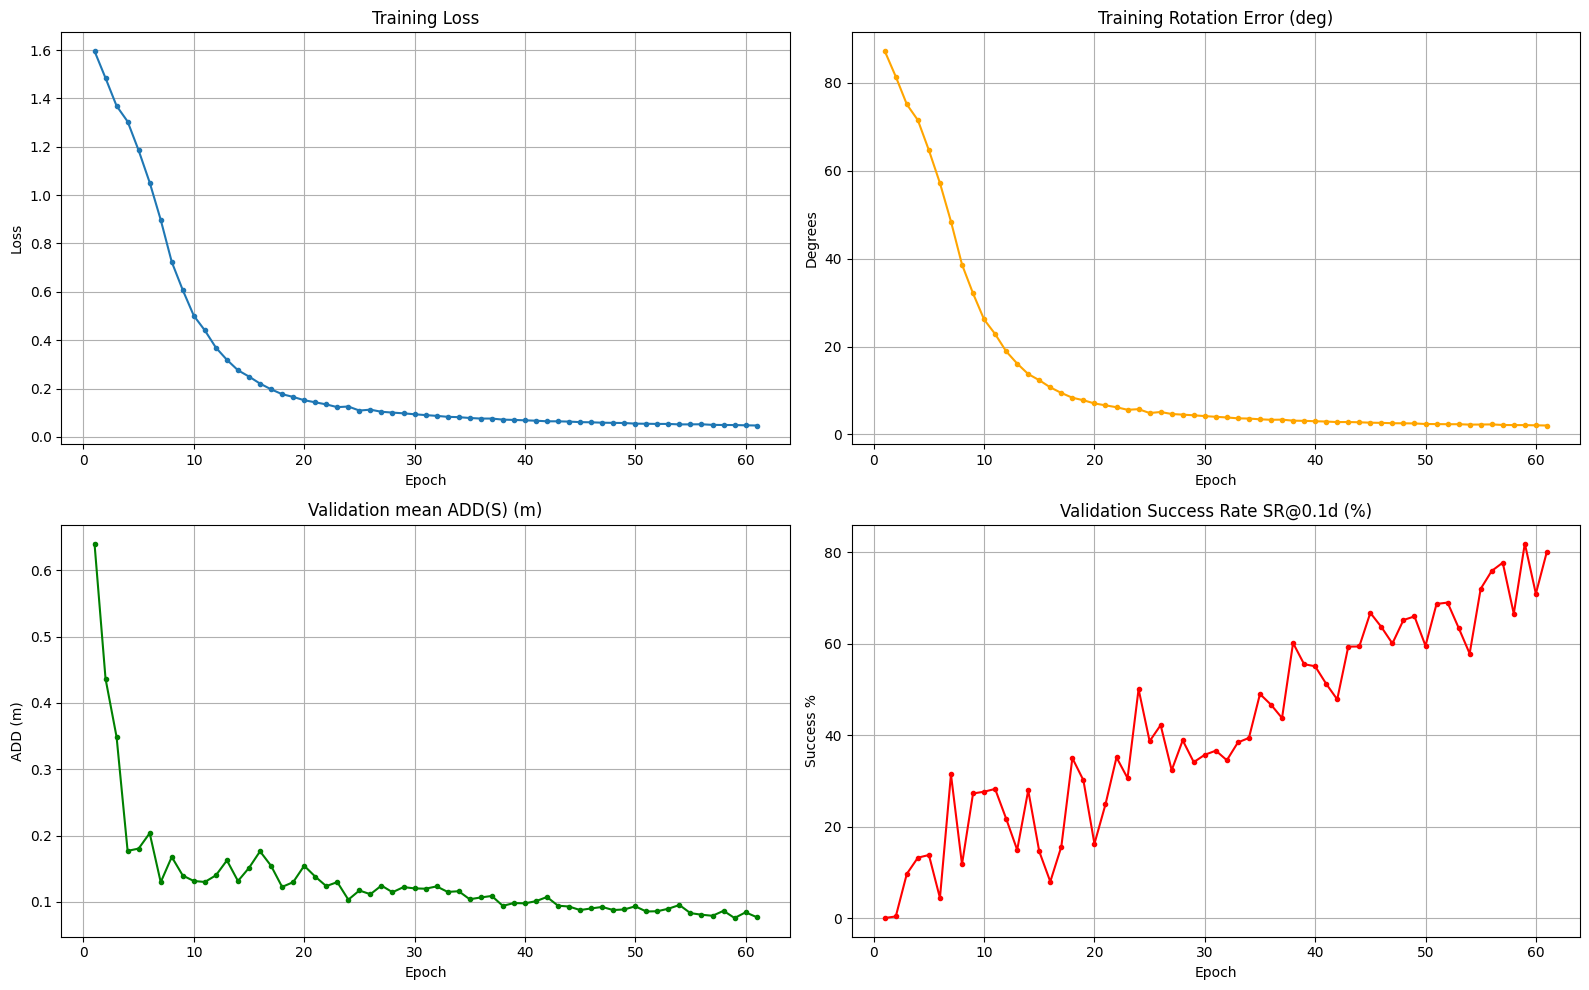

In [23]:
import re
import matplotlib.pyplot as plt

# ---- Paste your entire log text here ----
log_text = """
[001/61] train_loss=1.5959 | train_rot_deg=87.26 | train_tL1=0.0729  ||  val_mean_ADD(S)=0.640623 | val_SR@0.1d=0.00%                                                      
[002/61] train_loss=1.4840 | train_rot_deg=81.43 | train_tL1=0.0628  ||  val_mean_ADD(S)=0.436506 | val_SR@0.1d=0.34% 
[003/61] train_loss=1.3690 | train_rot_deg=75.13 | train_tL1=0.0577  ||  val_mean_ADD(S)=0.348809 | val_SR@0.1d=9.66%                                                      
[004/61] train_loss=1.3044 | train_rot_deg=71.53 | train_tL1=0.0560  ||  val_mean_ADD(S)=0.176831 | val_SR@0.1d=13.19%                                                      
[005/61] train_loss=1.1848 | train_rot_deg=64.68 | train_tL1=0.0559  ||  val_mean_ADD(S)=0.180320 | val_SR@0.1d=13.78%
[006/61] train_loss=1.0521 | train_rot_deg=57.21 | train_tL1=0.0536  ||  val_mean_ADD(S)=0.203558 | val_SR@0.1d=4.39%                   
[007/61] train_loss=0.8978 | train_rot_deg=48.46 | train_tL1=0.0521  ||  val_mean_ADD(S)=0.129540 | val_SR@0.1d=31.39%                                                                                                                     
[008/61] train_loss=0.7235 | train_rot_deg=38.67 | train_tL1=0.0485  ||  val_mean_ADD(S)=0.167686 | val_SR@0.1d=11.73%
[009/61] train_loss=0.6070 | train_rot_deg=32.10 | train_tL1=0.0469  ||  val_mean_ADD(S)=0.139529 | val_SR@0.1d=27.24%
[010/61] train_loss=0.5010 | train_rot_deg=26.18 | train_tL1=0.0440  ||  val_mean_ADD(S)=0.131371 | val_SR@0.1d=27.62%
[011/61] train_loss=0.4404 | train_rot_deg=22.86 | train_tL1=0.0415  ||  val_mean_ADD(S)=0.129891 | val_SR@0.1d=28.23%
[012/61] train_loss=0.3691 | train_rot_deg=18.92 | train_tL1=0.0389  ||  val_mean_ADD(S)=0.139916 | val_SR@0.1d=21.73%
[013/61] train_loss=0.3187 | train_rot_deg=16.13 | train_tL1=0.0373  ||  val_mean_ADD(S)=0.162477 | val_SR@0.1d=14.89%
[014/61] train_loss=0.2756 | train_rot_deg=13.75 | train_tL1=0.0357  ||  val_mean_ADD(S)=0.131301 | val_SR@0.1d=27.93%
[015/61] train_loss=0.2495 | train_rot_deg=12.35 | train_tL1=0.0340  ||  val_mean_ADD(S)=0.151157 | val_SR@0.1d=14.56%
[016/61] train_loss=0.2204 | train_rot_deg=10.72 | train_tL1=0.0333  ||  val_mean_ADD(S)=0.176165 | val_SR@0.1d=7.95%
[017/61] train_loss=0.1968 | train_rot_deg=9.45 | train_tL1=0.0319  ||  val_mean_ADD(S)=0.154254 | val_SR@0.1d=15.61% 
[018/61] train_loss=0.1766 | train_rot_deg=8.36 | train_tL1=0.0306  ||  val_mean_ADD(S)=0.122438 | val_SR@0.1d=34.98% 
[019/61] train_loss=0.1653 | train_rot_deg=7.79 | train_tL1=0.0294  ||  val_mean_ADD(S)=0.129594 | val_SR@0.1d=30.13% 
[020/61] train_loss=0.1517 | train_rot_deg=7.06 | train_tL1=0.0284  ||  val_mean_ADD(S)=0.154373 | val_SR@0.1d=16.24% 
[021/61] train_loss=0.1430 | train_rot_deg=6.63 | train_tL1=0.0273  ||  val_mean_ADD(S)=0.137985 | val_SR@0.1d=24.85% 
[022/61] train_loss=0.1344 | train_rot_deg=6.20 | train_tL1=0.0263  ||  val_mean_ADD(S)=0.123628 | val_SR@0.1d=35.13% 
[023/61] train_loss=0.1230 | train_rot_deg=5.61 | train_tL1=0.0251  ||  val_mean_ADD(S)=0.129701 | val_SR@0.1d=30.59% 
[024/61] train_loss=0.1256 | train_rot_deg=5.76 | train_tL1=0.0251  ||  val_mean_ADD(S)=0.103154 | val_SR@0.1d=50.06% 
[025/61] train_loss=0.1090 | train_rot_deg=4.88 | train_tL1=0.0238  ||  val_mean_ADD(S)=0.117039 | val_SR@0.1d=38.67% 
[026/61] train_loss=0.1126 | train_rot_deg=5.11 | train_tL1=0.0235  ||  val_mean_ADD(S)=0.111418 | val_SR@0.1d=42.19% 
[027/61] train_loss=0.1039 | train_rot_deg=4.66 | train_tL1=0.0227  ||  val_mean_ADD(S)=0.124454 | val_SR@0.1d=32.32% 
[028/61] train_loss=0.1005 | train_rot_deg=4.51 | train_tL1=0.0218  ||  val_mean_ADD(S)=0.114408 | val_SR@0.1d=38.86% 
[029/61] train_loss=0.0974 | train_rot_deg=4.36 | train_tL1=0.0213  ||  val_mean_ADD(S)=0.122148 | val_SR@0.1d=34.09% 
[030/61] train_loss=0.0936 | train_rot_deg=4.18 | train_tL1=0.0207  ||  val_mean_ADD(S)=0.120203 | val_SR@0.1d=35.70% 
[031/61] train_loss=0.0901 | train_rot_deg=4.02 | train_tL1=0.0199  ||  val_mean_ADD(S)=0.119734 | val_SR@0.1d=36.60% 
[032/61] train_loss=0.0870 | train_rot_deg=3.87 | train_tL1=0.0194  ||  val_mean_ADD(S)=0.123209 | val_SR@0.1d=34.51% 
[033/61] train_loss=0.0830 | train_rot_deg=3.67 | train_tL1=0.0189  ||  val_mean_ADD(S)=0.114894 | val_SR@0.1d=38.40% 
[034/61] train_loss=0.0816 | train_rot_deg=3.62 | train_tL1=0.0184  ||  val_mean_ADD(S)=0.115923 | val_SR@0.1d=39.39% 
[035/61] train_loss=0.0782 | train_rot_deg=3.45 | train_tL1=0.0179  ||  val_mean_ADD(S)=0.103817 | val_SR@0.1d=48.99% 
[036/61] train_loss=0.0758 | train_rot_deg=3.34 | train_tL1=0.0175  ||  val_mean_ADD(S)=0.106510 | val_SR@0.1d=46.65% 
[037/61] train_loss=0.0758 | train_rot_deg=3.37 | train_tL1=0.0170  ||  val_mean_ADD(S)=0.108805 | val_SR@0.1d=43.73% 
[038/61] train_loss=0.0714 | train_rot_deg=3.14 | train_tL1=0.0166  ||  val_mean_ADD(S)=0.093843 | val_SR@0.1d=60.15% 
[039/61] train_loss=0.0702 | train_rot_deg=3.10 | train_tL1=0.0162  ||  val_mean_ADD(S)=0.098068 | val_SR@0.1d=55.51% 
[040/61] train_loss=0.0685 | train_rot_deg=3.01 | train_tL1=0.0160  ||  val_mean_ADD(S)=0.097637 | val_SR@0.1d=55.06% 
[041/61] train_loss=0.0669 | train_rot_deg=2.94 | train_tL1=0.0155  ||  val_mean_ADD(S)=0.100901 | val_SR@0.1d=51.22% 
[042/61] train_loss=0.0645 | train_rot_deg=2.82 | train_tL1=0.0153  ||  val_mean_ADD(S)=0.107202 | val_SR@0.1d=47.81% 
[043/61] train_loss=0.0644 | train_rot_deg=2.83 | train_tL1=0.0150  ||  val_mean_ADD(S)=0.094080 | val_SR@0.1d=59.35% 
[044/61] train_loss=0.0632 | train_rot_deg=2.77 | train_tL1=0.0148  ||  val_mean_ADD(S)=0.092826 | val_SR@0.1d=59.39% 
[045/61] train_loss=0.0611 | train_rot_deg=2.68 | train_tL1=0.0143  ||  val_mean_ADD(S)=0.087511 | val_SR@0.1d=66.75% 
[046/61] train_loss=0.0603 | train_rot_deg=2.64 | train_tL1=0.0142  ||  val_mean_ADD(S)=0.089934 | val_SR@0.1d=63.65% 
[047/61] train_loss=0.0587 | train_rot_deg=2.56 | train_tL1=0.0140  ||  val_mean_ADD(S)=0.092201 | val_SR@0.1d=60.04% 
[048/61] train_loss=0.0580 | train_rot_deg=2.54 | train_tL1=0.0137  ||  val_mean_ADD(S)=0.087524 | val_SR@0.1d=65.17% 
[049/61] train_loss=0.0574 | train_rot_deg=2.51 | train_tL1=0.0136  ||  val_mean_ADD(S)=0.088423 | val_SR@0.1d=65.97% 
[050/61] train_loss=0.0548 | train_rot_deg=2.38 | train_tL1=0.0132  ||  val_mean_ADD(S)=0.093146 | val_SR@0.1d=59.54% 
[051/61] train_loss=0.0543 | train_rot_deg=2.36 | train_tL1=0.0131  ||  val_mean_ADD(S)=0.085337 | val_SR@0.1d=68.69% 
[052/61] train_loss=0.0536 | train_rot_deg=2.33 | train_tL1=0.0129  ||  val_mean_ADD(S)=0.085725 | val_SR@0.1d=68.99% 
[053/61] train_loss=0.0536 | train_rot_deg=2.33 | train_tL1=0.0129  ||  val_mean_ADD(S)=0.089510 | val_SR@0.1d=63.48% 
[054/61] train_loss=0.0516 | train_rot_deg=2.24 | train_tL1=0.0124  ||  val_mean_ADD(S)=0.095135 | val_SR@0.1d=57.83% 
[055/61] train_loss=0.0518 | train_rot_deg=2.26 | train_tL1=0.0124  ||  val_mean_ADD(S)=0.082873 | val_SR@0.1d=72.00% 
[056/61] train_loss=0.0522 | train_rot_deg=2.29 | train_tL1=0.0122  ||  val_mean_ADD(S)=0.080499 | val_SR@0.1d=75.91% 
[057/61] train_loss=0.0497 | train_rot_deg=2.16 | train_tL1=0.0120  ||  val_mean_ADD(S)=0.078853 | val_SR@0.1d=77.72% 
[058/61] train_loss=0.0492 | train_rot_deg=2.13 | train_tL1=0.0120  ||  val_mean_ADD(S)=0.086366 | val_SR@0.1d=66.54% 
[059/61] train_loss=0.0490 | train_rot_deg=2.13 | train_tL1=0.0118  ||  val_mean_ADD(S)=0.075520 | val_SR@0.1d=81.90% 
[060/61] train_loss=0.0479 | train_rot_deg=2.08 | train_tL1=0.0117  ||  val_mean_ADD(S)=0.084090 | val_SR@0.1d=70.93% 
[061/61] train_loss=0.0471 | train_rot_deg=2.04 | train_tL1=0.0115  ||  val_mean_ADD(S)=0.076858 | val_SR@0.1d=80.13%
"""

# ---------- Parsing ----------
epochs = []
train_loss = []
train_rot = []
train_t = [] # This is 'train_tL1' but not plotted in the user's original request
val_add = []
val_sr = []

# Corrected pattern: removed 'OBJ01_' from the validation metrics
# The \s+ and \u00a0 (non-breaking space) are kept to handle the specific log format spacing.
pattern = r"\[(\d+)/\d+\] train_loss=([\d.]+) \| train_rot_deg=([\d.]+) \| train_tL1=([\d.]+)\s+\|\|  val_mean_ADD\(S\)=([\d.]+) \| val_SR@0\.1d=([\d.]+)%"

for line in log_text.strip().split("\n"):
    m = re.search(pattern, line)
    if m:
        # Group 1: Epoch, Group 2: train_loss, Group 3: train_rot_deg, Group 4: train_tL1, 
        # Group 5: val_mean_ADD(S), Group 6: val_SR@0.1d
        ep = int(m.group(1))
        epochs.append(ep)
        train_loss.append(float(m.group(2)))
        train_rot.append(float(m.group(3)))
        train_t.append(float(m.group(4)))
        val_add.append(float(m.group(5)))
        val_sr.append(float(m.group(6)))

# ---------- Plotting ----------
plt.figure(figsize=(16,10))

# Train Loss
plt.subplot(2,2,1)
plt.plot(epochs, train_loss, marker='o', markersize=3, linestyle='-')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Train rotation error
plt.subplot(2,2,2)
plt.plot(epochs, train_rot, marker='o', markersize=3, linestyle='-', color='orange')
plt.title("Training Rotation Error (deg)")
plt.xlabel("Epoch")
plt.ylabel("Degrees")
plt.grid(True)

# Validation ADD(S)
plt.subplot(2,2,3)
plt.plot(epochs, val_add, marker='o', markersize=3, linestyle='-', color='green')
plt.title("Validation mean ADD(S) (m)")
plt.xlabel("Epoch")
plt.ylabel("ADD (m)")
plt.grid(True)

# Success Rate @ 0.1d
plt.subplot(2,2,4)
plt.plot(epochs, val_sr, marker='o', markersize=3, linestyle='-', color='red')
plt.title("Validation Success Rate SR@0.1d (%)")
plt.xlabel("Epoch")
plt.ylabel("Success %")
plt.grid(True)

plt.tight_layout()
plt.savefig('log_metrics.png')